In [1]:
%matplotlib inline

## [Birch](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html#sklearn.cluster.Birch) Clustering
- Builds a _clustering feature tree (CFT)_. Each subcluster contains enough meta information to not need the entire cluster in memory:
    - #samples
    - linear sum (n-dimensional vector with sum of all samples)
    - squared sum (sum of squared L2 norm of all samples)
    - centroids
    - squared norm of centroids
- ```threshold```: limits the distance between the entering sample & existing subclusters
- ```branching factor```: limits the #subclusters in a node.
- Does not scale well. If ```n_features<20```, consider using MiniBatchKmeans instead.

## Example: Compare Birch to MiniBatch KMeans
- synthetic dataset, 100K samples, 2 features (make_blobs)
- if ```n_clusters=None```, data is reduced from 100K samples to 158 clusters. Can be viewed as preliminary step before final global clustering - further reducing #clusters to 100.

In [2]:
from itertools import cycle
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets import make_blobs

# Generate centers for the blobs so that it forms a 10 X 10 grid.
xx        = np.linspace(-22, 22, 10)
yy        = np.linspace(-22, 22, 10)
xx, yy    = np.meshgrid(xx, yy)
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                       np.ravel(yy)[:, np.newaxis]))

# Generate blobs to do a comparison between MiniBatchKMeans and Birch.
X, y = make_blobs(n_samples=100000, 
                  centers=n_centres, 
                  random_state=0)

colors_ = cycle(colors.cnames.keys())


Birch without global clustering as the final step took 2.94 seconds
n_clusters : 158
Birch with global clustering as the final step took 3.05 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 4.04 seconds


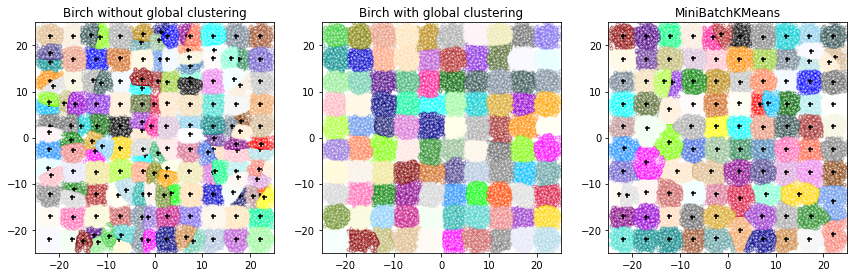

In [3]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

birch_models = [Birch(threshold=1.7, n_clusters=None),
                Birch(threshold=1.7, n_clusters=100)]

final_step = ['without global clustering', 'with global clustering']

for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):

    t = time(); birch_model.fit(X); time_ = time() - t
    
    print("Birch %s as the final step took %0.2f seconds" % (
          info, (time() - t)))

    # Plot result
    labels     = birch_model.labels_
    centroids  = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size

    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1],
                   c='w', edgecolor=col, marker='.', alpha=0.5)
        if birch_model.n_clusters is None:
            ax.scatter(this_centroid[0], this_centroid[1], marker='+',
                       c='k', s=25)

    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title('Birch %s' % info)

# Compute clustering with MiniBatchKMeans.
mbk = MiniBatchKMeans(init='k-means++', 
                      n_clusters=100, 
                      batch_size=100,
                      n_init=10, 
                      max_no_improvement=10, 
                      verbose=0,
                      random_state=0)

t0 = time(); mbk.fit(X); t_mini_batch = time() - t0

print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)

mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)

for this_centroid, k, col in zip(mbk.cluster_centers_,
                                 range(n_clusters), colors_):
    mask = mbk.labels_ == k

    ax.scatter(X[mask, 0], 
               X[mask, 1], marker='.',
               c='w', edgecolor=col, alpha=0.5)
    ax.scatter(this_centroid[0], 
               this_centroid[1], marker='+',
               c='k', s=25)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()